In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from datetime import datetime, date, time, timedelta
from tqdm import tqdm, trange
from corr_utils import *

In [2]:
directory = './data/ground_truth/sdot/2022_01'
occ = pd.DataFrame()

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if not filename.startswith('.') and os.path.isfile(f):
        df = pd.read_csv(f)
        occ = pd.concat([occ, df], ignore_index=True)
        
occ = occ.drop(columns=['Unnamed: 0','Route','Label','Side of Street','Notes','Pictures'])
occ['Time'] = occ.apply(lambda r: datetime.strptime(r['Time'], '%I%p').time(), axis=1)
occ['Hour'] = occ.apply(lambda r: r['Time'].hour, axis=1)
occ['Date'] = occ.apply(lambda r: datetime.strptime(r['Date'], '%m/%d/%Y').date(), axis=1)
occ['DateTime'] = occ.apply(lambda r: datetime.combine(r['Date'],r['Time']), axis=1)
occ['Occupancy'] = occ[['PAID','Load Zone','RPZ for that Block','ADA','Rideshare','ILLEGAL']].sum(axis=1)

In [7]:
occ.head()

Time        Date  Element Key                                Location  \
0  08:00:00  2022-08-25         8369  8TH AVE BETWEEN JAMES ST AND CHERRY ST   
1  09:00:00  2022-08-25         8369  8TH AVE BETWEEN JAMES ST AND CHERRY ST   
2  10:00:00  2022-08-25         8369  8TH AVE BETWEEN JAMES ST AND CHERRY ST   
3  11:00:00  2022-08-25         8369  8TH AVE BETWEEN JAMES ST AND CHERRY ST   
4  12:00:00  2022-08-25         8369  8TH AVE BETWEEN JAMES ST AND CHERRY ST   

   PAID  Load Zone  RPZ for that Block  ADA  Rideshare  ILLEGAL  Hour  \
0     1          1                   0    2          0        0     8   
1     3          1                   0    1          0        0     9   
2     5          0                   0    1          0        0    10   
3     3          1                   0    1          0        0    11   
4     2          1                   0    1          0        0    12   

             DateTime  Occupancy  
0 2022-08-25 08:00:00          4  
1 2022-08-25 09:00:00          5  
2 2022-08-25 10:00:00          6  
3 2022-08-25 11:00:00          5  
4 2022-08-25 12:00:00          4

In [19]:
grouped = occ.groupby(['Element Key','Date'])

occ_dict = {}

for (ekey,date),group in tqdm(grouped):
    if occ_dict.get(ekey) == None:
        occ_dict[ekey] = {}
    occupancy = []
    for hr in timerange():
        count = group[group['Hour']==hr]['Occupancy'].sum()
        occupancy.append(count)
    occ_dict[ekey][date] = occupancy

100%|████████████████████████████████████████| 400/400 [00:00<00:00, 612.65it/s]


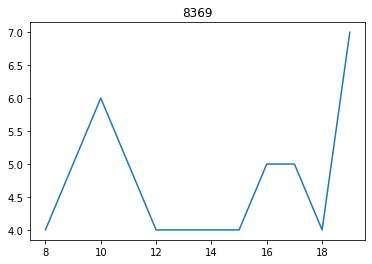

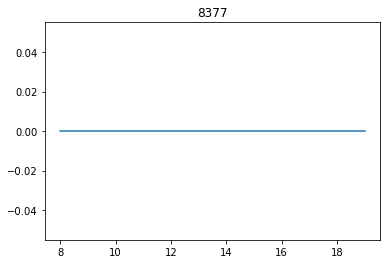

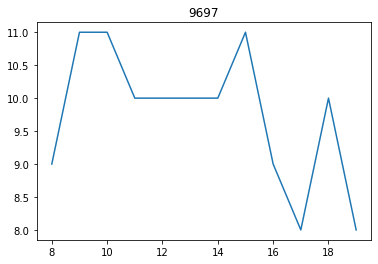

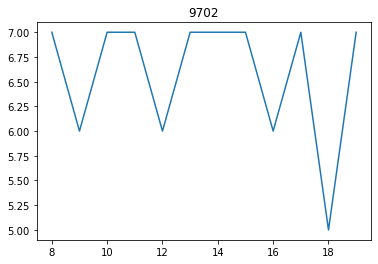

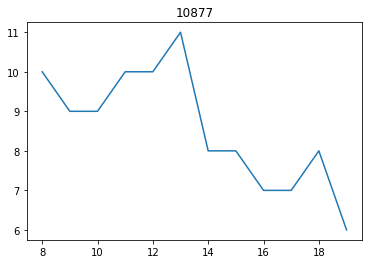

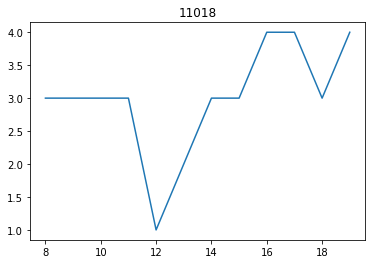

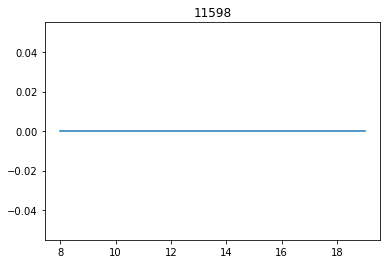

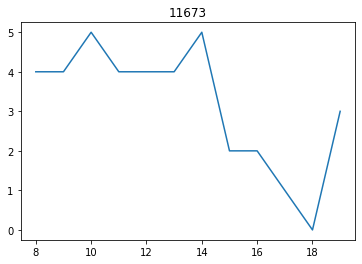

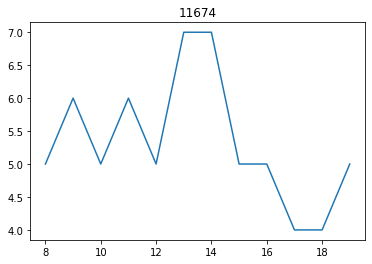

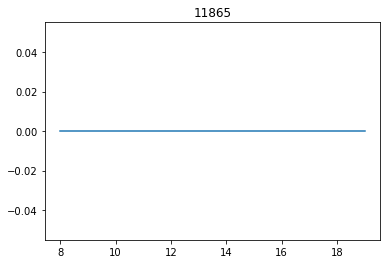

In [20]:
for ekey in occ['Element Key'].unique()[:10]:
    occupancy = []
    for date in occ_dict[ekey]:
        occupancy.append(occ_dict[ekey][date])
    occupancy = np.array(occupancy)
    occupancy = occupancy.reshape((-1,12))
    hours = [8+i for i in range(12)]
    plt.figure()
    plt.title(ekey)
    plt.plot(hours,np.mean(occupancy,axis=0))
    plt.fill_between(hours,
                     np.mean(occupancy,axis=0)-np.std(occupancy,axis=0),
                     np.mean(occupancy,axis=0)+np.std(occupancy,axis=0),
                     alpha=0.2)
    plt.show()

In [22]:
corr_dict = {}
for block_id_1 in tqdm(occ_dict):
    corr_dict[block_id_1] = {}
    for block_id_2 in occ_dict:
        b1_demand = []
        b2_demand = []
        for date in occ_dict[block_id_1]:
            b1_demand.extend(occ_dict[block_id_1][date])
            b2_demand.extend(occ_dict[block_id_2].get(date,[]))
        b1_demand = np.array(b1_demand)
        b2_demand = np.array(b2_demand)
        r,n = pearson_corr(b1_demand,b2_demand)
        r_U,r_L = corr_interval(r,n,0.05)
        corr_dict[block_id_1][block_id_2] = (r,r_U,r_L)

100%|████████████████████████████████████████| 400/400 [00:01<00:00, 217.04it/s]


In [23]:
corr_dict

{1013: {1013: (1.0, 0.9999999999999998, 0.9999999999999963),
  1014: (0.06372529878771661, 0.6151303371118032, -0.5295427844838869),
  1433: (0.0, 1, -1),
  1434: (0.0, 1, -1),
  2089: (0.0, 1, -1),
  2090: (0.0, 1, -1),
  3081: (0.0, 1, -1),
  3082: (0.0, 1, -1),
  3337: (0.0, 1, -1),
  3338: (0.0, 1, -1),
  3341: (0.0, 1, -1),
  3342: (0.0, 1, -1),
  7397: (0.0, 1, -1),
  7398: (0.0, 1, -1),
  7989: (-0.5570860145311556, 0.024718378738092503, -0.8569954260644831),
  7993: (0.3333333333333333, 0.761550020873238, -0.2974755088640591),
  7997: (0.0, 1, -1),
  8001: (0.0, 1, -1),
  8002: (0.0, 1, -1),
  8005: (0.0, 1, -1),
  8097: (0.0, 1, -1),
  8098: (0.0, 1, -1),
  8101: (0.0, 1, -1),
  8102: (0.0, 1, -1),
  8249: (0.0, 1, -1),
  8301: (0.0, 1, -1),
  8302: (0.0, 1, -1),
  8305: (0.0, 1, -1),
  8306: (0.0, 1, -1),
  8369: (0.0, 1, -1),
  8377: (0.0, 1, -1),
  8386: (0.6762522260005742, 0.9006208632008522, 0.16726750232659565),
  8389: (0.0, 1, -1),
  8393: (0.0, 1, -1),
  8394: (0.0, 